In [1]:
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit, transpile
from qiskit_aer import AerSimulator

from LogicalQ.Logical import LogicalCircuit
from LogicalQ.Library.QECCs import steane_code

from LogicalQ.NoiseModel import (
    construct_noise_model,
    construct_noise_model_QuantinuumH1_1,
    construct_noise_model_QuantinuumH2_1,
    construct_noise_model_QuantinuumH2_2,
)

from LogicalQ.Benchmarks import (
    n_qubit_ghz_generation,
    quantum_teleportation,
    mirror_benchmarking,
    randomized_benchmarking,
    quantum_volume,
)

from LogicalQ.Experiments import (
    execute_circuits,
    circuit_scaling_experiment,
    noise_scaling_experiment,
    qec_cycle_efficiency_experiment,
    qec_cycle_noise_scaling_experiment,
)

from LogicalQ.Analysis import (
    circuit_scaling_bar3d,
    noise_model_scaling_bar,
    qec_cycle_efficiency_bar,
)

# Noise Models

In [2]:
noise_model_QuantinuumH1_1 = construct_noise_model_QuantinuumH1_1(n_qubits=2)
noise_model_QuantinuumH2_1 = construct_noise_model_QuantinuumH2_1(n_qubits=2)
noise_model_QuantinuumH2_2 = construct_noise_model_QuantinuumH2_2(n_qubits=2)

Noise models built


# Circuit Scaling

In [3]:
# Construct circuit factories as circuit inputs
physical_circuit_factory = lambda n_qubits, circuit_length : mirror_benchmarking(n_qubits=n_qubits, circuit_length=circuit_length, measure=True)

def log_mirror_benchmarking(n_qubits, circuit_length):
    pqc = physical_circuit_factory(n_qubits, circuit_length)
    lqc = LogicalCircuit.from_physical_circuit(pqc, **steane_code)
    # lqc.measure_all(with_error_correction=False)
    return lqc

logical_circuit_factory = log_mirror_benchmarking

# Construct noise model factories as noise model inputs
noise_model_factory = construct_noise_model_QuantinuumH1_1

## Serial

In [4]:
phys_data_serial = circuit_scaling_experiment(
    physical_circuit_factory,
    noise_model_factory,
    min_n_qubits=1,
    max_n_qubits=2,
    min_circuit_length=1,
    max_circuit_length=64,
    shots=128,
    with_mp=False
)

WARNING - gate_sample contains non-Clifford gates
WARNING - gate_sample contains non-Clifford gates
WARNING - gate_sample contains non-Clifford gates
WARNING - gate_sample contains non-Clifford gates
WARNING - gate_sample contains non-Clifford gates
WARNING - gate_sample contains non-Clifford gates
WARNING - gate_sample contains non-Clifford gates
WARNING - gate_sample contains non-Clifford gates
WARNING - gate_sample contains non-Clifford gates
WARNING - gate_sample contains non-Clifford gates
WARNING - gate_sample contains non-Clifford gates
WARNING - gate_sample contains non-Clifford gates
WARNING - gate_sample contains non-Clifford gates
WARNING - gate_sample contains non-Clifford gates
WARNING - gate_sample contains non-Clifford gates
WARNING - gate_sample contains non-Clifford gates
WARNING - gate_sample contains non-Clifford gates
WARNING - gate_sample contains non-Clifford gates
WARNING - gate_sample contains non-Clifford gates
WARNING - gate_sample contains non-Clifford gates


In [5]:
log_data_serial = circuit_scaling_experiment(
    logical_circuit_factory,
    noise_model_factory,
    min_n_qubits=1,
    max_n_qubits=2,
    min_circuit_length=1,
    max_circuit_length=1,
    shots=128,
    with_mp=False
)

WARNING - gate_sample contains non-Clifford gates
WARNING - gate_sample contains non-Clifford gates
Completed experiment in 2.242712360981386 seconds


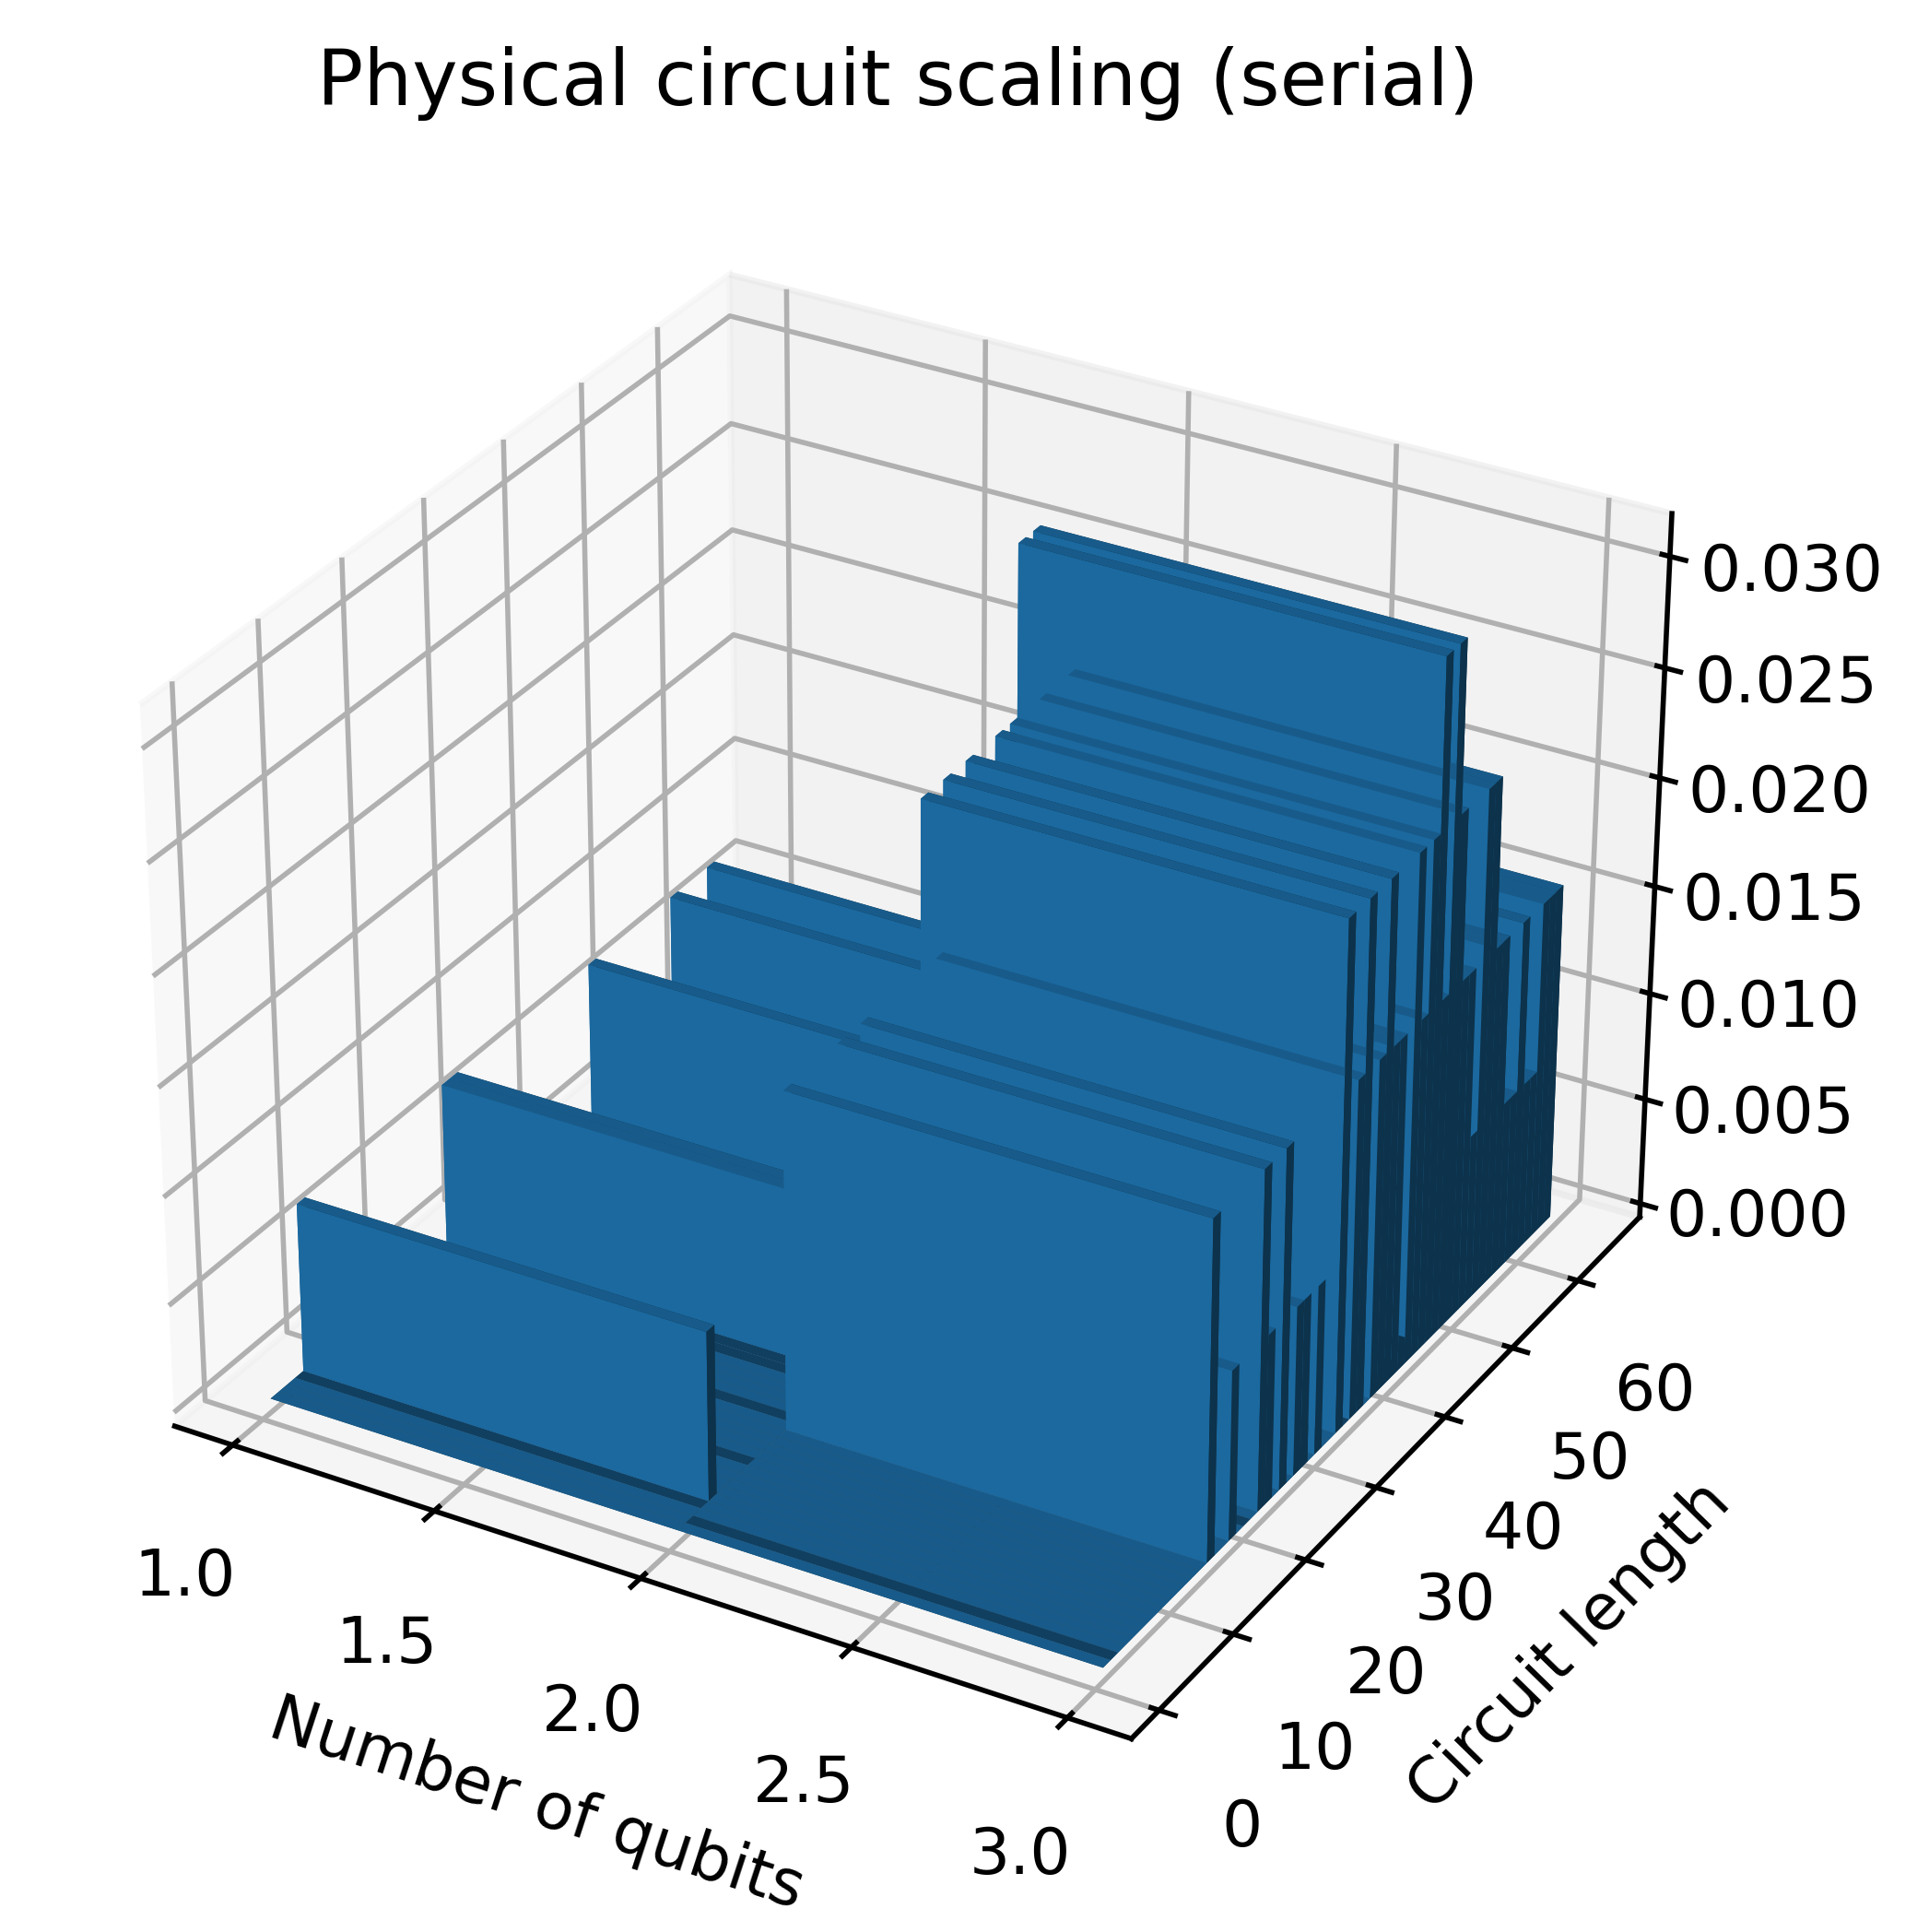

<module 'matplotlib.pyplot' from '/home/rasmitdevkota/.venvs/qiskit/lib/python3.13/site-packages/matplotlib/pyplot.py'>

In [6]:
circuit_scaling_bar3d(phys_data_serial, title="Physical circuit scaling (serial)", show=True)

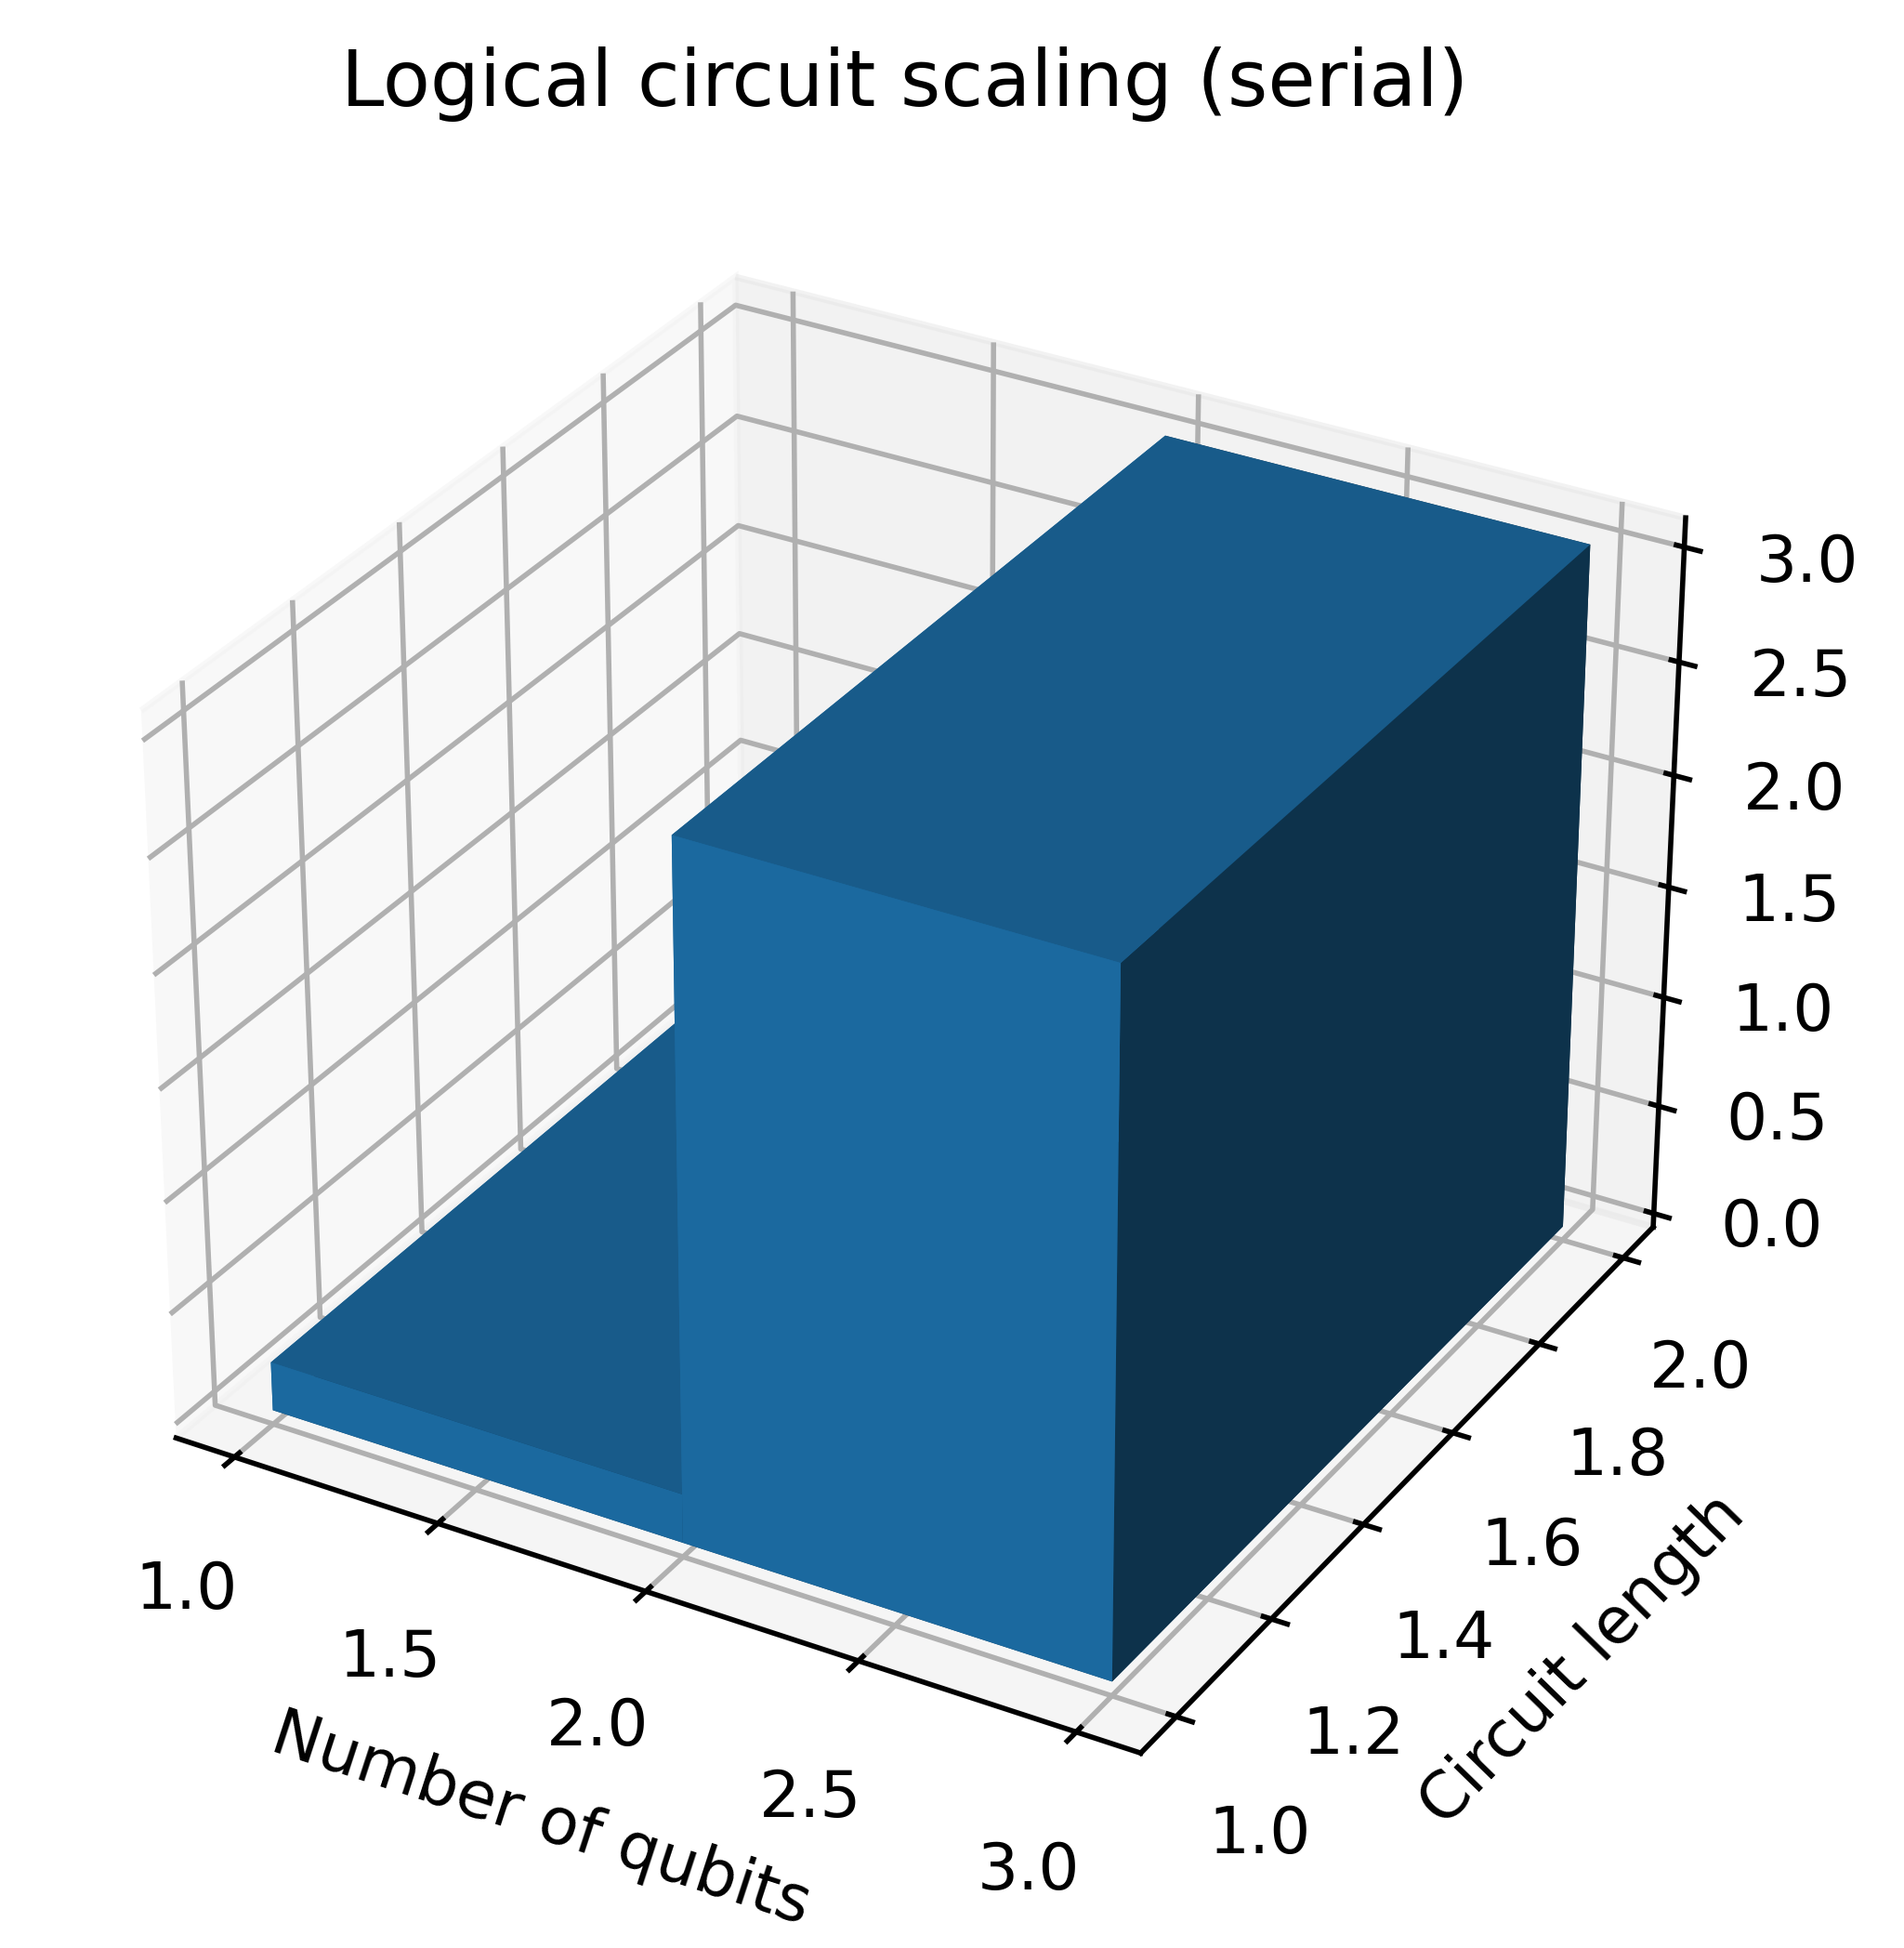

<module 'matplotlib.pyplot' from '/home/rasmitdevkota/.venvs/qiskit/lib/python3.13/site-packages/matplotlib/pyplot.py'>

In [7]:
circuit_scaling_bar3d(log_data_serial, title="Logical circuit scaling (serial)", show=True)

## With MP

In [ ]:
phys_data_mp = circuit_scaling_experiment(
    physical_circuit_factory,
    noise_model_factory,
    min_n_qubits=1,
    max_n_qubits=2,
    min_circuit_length=1,
    max_circuit_length=2,
    shots=128,
    with_mp=True
)

WARNING - gate_sample contains non-Clifford gates
WARNING - gate_sample contains non-Clifford gates
WARNING - gate_sample contains non-Clifford gates
WARNING - gate_sample contains non-Clifford gates
Applying mulitprocessing to 4 samples in batches of maximum size 1 across 16 CPUs
724550 724551starting 
starting
724552 starting
724553 starting


In [ ]:
log_data_mp = circuit_scaling_experiment(
    logical_circuit_factory,
    noise_model_factory,
    min_n_qubits=1,
    max_n_qubits=2,
    min_circuit_length=1,
    max_circuit_length=1,
    shots=128,
    with_mp=True
)

In [ ]:
circuit_scaling_bar3d(phys_data_mp, title="Physical circuit scaling (mp)", show=True)

In [ ]:
circuit_scaling_bar3d(log_data_mp, title="Logical circuit scaling (mp)", show=True)

# Noise Model Scaling

In [ ]:
# Sweep 3x3x3 = 27 combinations of noise values.
error_scan_keys = ["amplitude_damping_error_1q", "depolarizing_error_2q", "readout_error_0|1"]
error_scan_val_lists = [
    [0.0, 2e-4, 1e-3],   # 1q amplitude
    [0.0, 5e-3, 2e-2],   # 2q depol
    [0.0, 5e-3, 5e-2],   # readout 0->1
]
lqc = log_mirror_benchmarking(n_qubits=3, circuit_length=4)
phys3 = mirror_benchmarking(n_qubits=3, circuit_length=4)

base_noise_model = construct_noise_model_QuantinuumH1_1()

# compute_exact=True only works for fully unitary circuits (no measurements or classical control)
lqc_unitary = log_mirror_benchmarking(n_qubits=3, circuit_length=4, measure=False)

## Logical circuit

In [ ]:
noise_data_logical_all_true = noise_scaling_experiment(
    circuit_input=lqc_unitary,
    noise_model_input=base_noise_model,
    error_scan_keys=error_scan_keys,
    error_scan_val_lists=error_scan_val_lists,
    compute_exact=True,
    shots=0,
    with_mp=True
)

noise_model_scaling_bar(noise_data_logical_all_true, scan_keys=error_scan_keys, separate_plots=True)

In [ ]:
noise_data_logical_all_false = noise_scaling_experiment(
    circuit_input=lqc,
    noise_model_input=base_noise_model,
    error_scan_keys=error_scan_keys,
    error_scan_val_lists=error_scan_val_lists,
    compute_exact=False,
    shots=256,
    with_mp=False
)

noise_model_scaling_bar(noise_data_logical_all_false, scan_keys=error_scan_keys, separate_plots=False)

## Physical circuit

In [ ]:
noise_data_phys_all_true = noise_scaling_experiment(
    circuit_input=phys3,
    noise_model_input=base_noise_model,
    error_scan_keys=error_scan_keys,
    error_scan_val_lists=error_scan_val_lists,
    compute_exact=True,
    shots=0,
    with_mp=True
)


noise_model_scaling_bar(noise_data_phys_exact_mp, scan_keys=error_scan_keys, separate_plots=True)

In [ ]:
noise_data_phys_all_false = noise_scaling_experiment(
    circuit_input=phys3,
    noise_model_inputs=base_noise_model,
    error_scan_keys=error_scan_keys,
    error_scan_val_lists=error_scan_val_lists,
    compute_exact=False,
    shots=256,
    with_mp=False
)

noise_model_scaling_bar(noise_data_phys_mp, scan_keys=error_scan_keys, separate_plots=False)

# QEC Cycle Efficiency

In [ ]:
# Inject 0–4 cycles of Steane QEC and see how fidelity/num_cycle behaves.
# After n cycles, how much logical fidelity have we recovered per cycle?
config_scan_keys = ["cycles", "effective_threshold"]
config_scan_val_lists = [list(range(5)), [1e-3, 2e-3, 5e-3]] 

#lqc_single = log_mirror_benchmarking(n_qubits=3, circuit_length=4)
phys_single = mirror_benchmarking(n_qubits=3, circuit_length=4)

# Concrete noise model (base Quantinuum H1-1)
base_noise_model = construct_noise_model_QuantinuumH1_1()

## Serial

In [ ]:
qec_eff_data_serial = qec_cycle_efficiency_experiment(
    circuit_input = [phys_single],
    noise_model_input = base_noise_model,
    qecc = steane_code,
    constraint_scan_keys = config_scan_keys,
    constraint_scan_val_lists = config_scan_val_lists,
    method = "density_matrix",
    shots = 256,
    with_mp=False
)

In [ ]:
qec_cycle_efficiency_bar(qec_eff_data_serial)

## With MP

In [ ]:
qec_eff_data_mp = qec_cycle_efficiency_experiment(
    circuit_inputs = [lqc_single],
    noise_model_input = base_noise_model,
    constraint_scan_keys = config_scan_keys,
    constraint_scan_val_lists = config_scan_val_lists,
    method = "density_matrix",
    shots = 256,
    with_mp=True
)

In [ ]:
qec_cycle_efficiency_bar(qec_eff_data_mp)

# QEC Cycle Noise Scaling

In [ ]:
qec_noise_keys = ["p1q"]
qec_noise_vals = [[0.0, 1e-2]]

In [ ]:
qec_noise_scaling_serial = qec_cycle_noise_scaling_experiment(
    circuit_input=lqc_single,
    noise_model_input=base_noise_model,
    error_scan_keys=qec_noise_keys,
    error_scan_val_lists=qec_noise_vals,
    logical_kwargs=None,
    save_filename=None,
    with_mp=False
)

In [ ]:
qec_noise_scaling_mp = qec_cycle_noise_scaling_experiment(
    circuit_input=lqc_single,
    noise_model_input=base_noise_model,
    error_scan_keys=qec_noise_keys,
    error_scan_val_lists=qec_noise_vals,
    logical_kwargs=None,
    save_filename=None,
    with_mp=True
)